## Load Python Modules

In [1]:
import numpy as np 
import pandas as pd 
from skimage import filters
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, precision_recall_fscore_support
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torch
import matplotlib.pyplot as plt
import os
from image import *
from CNN import *
import util
%load_ext autoreload
%autoreload 2

## Show NVIDIA GPU

In [2]:
!nvidia-smi -L

GPU 0: NVIDIA H200 (UUID: GPU-0ac39896-e6a3-84e7-f18f-88e1e90e4e2e)


## Setup Utility

In [3]:
util.setup_logger()

# Load and Process Dataset

## Load Dataset

In [4]:
folder_path = os.path.join(os.getenv("HOME"), "scratch")
dataset = ImageDataset(os.path.join(folder_path, "train.csv"), use_augmentation=False, model="ViT")

## Check Dataset

In [5]:
dataset.check()

There are 0 missing values
39975 images with label 0, and 39975 with label 1.
All filenames end with .jpg


## (Optional) Show image for verification

Label: 0, shape: torch.Size([3, 512, 768])


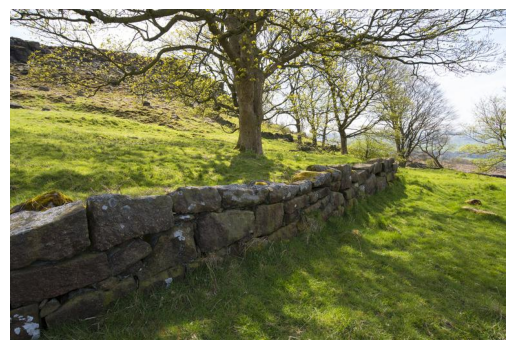

Label: 1, shape: torch.Size([3, 768, 592])


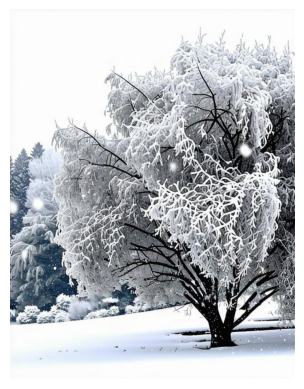

In [6]:
dataset.show_image()

## (Optional) Show normalized images

Label: 0, shape: torch.Size([3, 100, 100])
[WARNING] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


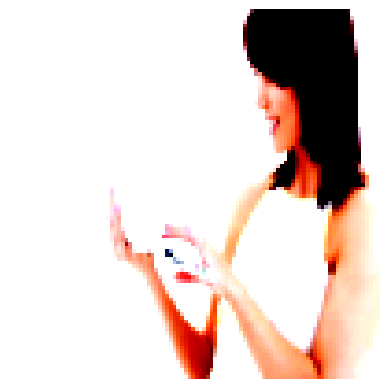

Label: 1, shape: torch.Size([3, 100, 100])
[WARNING] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


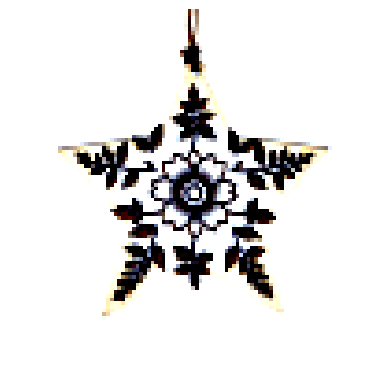

In [7]:
dataset.show_image(transform=True)

## Create Torch Data Loaders

In [6]:
loader = dataset.get_loader(shuffle=False, batch_size=64)

## Check CUDA Availability

In [7]:
# "cuda" only when GPUs are available.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


# Flatten Image for PCA

In [8]:
all_images = []
all_labels = []

for batch_idx, (images, labels) in enumerate(loader):
    images = images.to(device)
    labels = labels.to(device)

    edge_detected_images = []

    for i in range(3):  # Loop through R, G, B channels
        channel = images[:, i, :, :]  # (B, H, W)
        sobel_edges = []
        for img in channel.cpu().numpy(): 
            edge = filters.sobel(img)  # 2D Sobel edge detection
            sobel_edges.append(edge)
        sobel_tensor = torch.tensor(np.stack(sobel_edges)).to(device)  # (B, H, W)
        edge_detected_images.append(sobel_tensor)

    edge_detected_images = torch.stack(edge_detected_images, dim=1)  # (B, 3, H, W)
    
    batch_flat = edge_detected_images.view(edge_detected_images.size(0), -1)
    batch_flat_cpu = batch_flat.cpu().numpy()

    all_images.append(batch_flat_cpu)
    all_labels.append(labels.cpu().numpy())

numpy_images = np.vstack(all_images)
numpy_labels = np.concatenate(all_labels)


# Apply PCA

In [9]:
# Scale images
scaler = StandardScaler()
scaled_images = scaler.fit_transform(numpy_images)

#PCA using 20 components
pca = PCA(n_components=20)
X_pca = pca.fit_transform(scaled_images)

In [10]:
# Selecting 10,000 subsets
subset_indices = np.random.choice(X_pca.shape[0], size=10000, replace=False)
X_pca_sample = X_pca[subset_indices]
y_sample = numpy_labels[subset_indices]

In [13]:
# HDBSCAN and evaluation
import hdbscan
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, silhouette_score

clusterer = hdbscan.HDBSCAN(min_cluster_size=5,core_dist_n_jobs=1)
labels = clusterer.fit_predict(X_pca_sample)
mask = labels != -1 #exclude noise
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_noise = list(labels).count(-1)

if n_clusters > 1:
    ari = adjusted_rand_score(y_sample, labels)
    nmi = normalized_mutual_info_score(y_sample, labels)
    sil = silhouette_score(X_pca_sample[mask], labels[mask]) #exclude noise for silhouette_score

    print(f"Clusters found: {n_clusters}")
    print(f"Noise points: {n_noise}")
    print(f"ARI: {ari:.4f}")
    print(f"NMI: {nmi:.4f}")
    print(f"Silhouette Score: {sil:.4f}")
else:
    print("Not enough clusters.")


ModuleNotFoundError: No module named 'hdbscan'

In [14]:
# Confusion Matrix for DBSCAN (without the noise)
df = pd.DataFrame({
    'true_label': y_sample[mask],
    'cluster': labels[mask]
})

summary = pd.crosstab(df['cluster'], df['true_label'])
summary.index.name = 'Predicted Cluster'
summary.columns.name = 'True Label'

print('Confusion Matrix')
print(summary)# Majority of True Label of 1 is sorted as white noise 

#Accuracy
accuracy = np.trace(summary.values) / summary.values.sum()
print(f"Clustering Accuracy : {accuracy:.4f}") #Accuracy is high when high proportion of noise(87%) is dropped


NameError: name 'mask' is not defined

In [12]:
# Reduce to 2D using PCA for visualization
pca_vis = PCA(n_components=2)
X_vis = pca_vis.fit_transform(X_pca_sample)

# DBSCAN visualization(2 Dimension) with noise

plt.figure(figsize=(10, 6))
unique_labels = set(labels)

for label in unique_labels:
    label_mask = labels == label
    if label == -1:
        plt.scatter(X_vis[label_mask, 0], X_vis[label_mask, 1], 
                    c='lightgray', s=10, label='Noise', alpha=0.5)
    else:
        plt.scatter(X_vis[label_mask, 0], X_vis[label_mask, 1], 
                    s=10, label=f'Cluster {label}')

plt.title("HDBSCAN Clustering(PCA 2D) Visualization with the noise")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(markerscale=2)
plt.grid(True)
plt.tight_layout()
plt.show()

# DBSCAN visualization(2 Dimension) without noise

# Filter out noise
X_vis_filtered = X_vis[mask]
labels_filtered = labels[mask]

# Plot the points excluding the noise
plt.figure(figsize=(10, 6))
unique_labels = set(labels_filtered)

for label in unique_labels:
    label_mask = labels_filtered == label
    plt.scatter(X_vis_filtered[label_mask, 0], X_vis_filtered[label_mask, 1], 
                s=10, label=f'Cluster {label}')

plt.title("HDBSCAN Clustering(PCA 2D) Visualization without the noise")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(markerscale=2)
plt.grid(True)
plt.tight_layout()
plt.show()

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

<Figure size 1000x600 with 0 Axes>

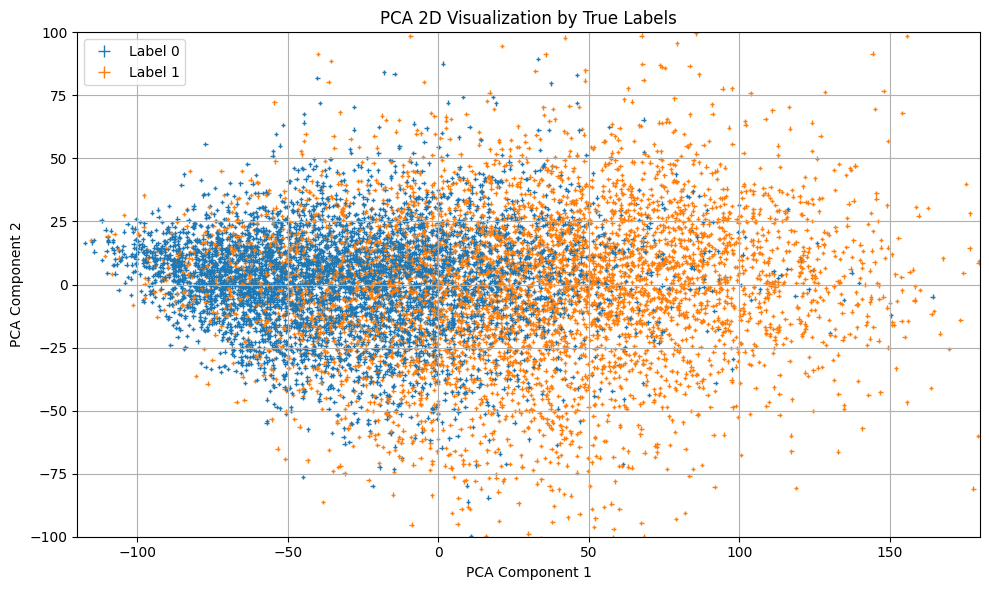

In [82]:
# Visualization for PCA(2D)
plt.figure(figsize=(10, 6))

# for label in np.unique(y_sample):
#     label_mask = y_sample == label
#     plt.scatter(X_vis[label_mask, 0], X_vis[label_mask, 1], 
#                 s=10, label=f'True Label {label}', alpha=0.7)
colors = np.where(y_sample == 0, 'tab:blue', 'tab:orange')
plt.scatter(X_vis[:, 0], X_vis[:, 1], c=colors, marker='+', s=10, lw=1)
from matplotlib.lines import Line2D
legend_elems = [
    Line2D([0],[0], marker='+', linestyle='None',
           color='tab:blue',  label='Label 0', markersize=8),
    Line2D([0],[0], marker='+', linestyle='None',
           color='tab:orange', label='Label 1', markersize=8)
]
plt.legend(handles=legend_elems)
plt.title("PCA 2D Visualization by True Labels")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.xlim(-120, 180)
plt.ylim(-100, 100)
# plt.legend(markerscale=2)
plt.grid(True)
plt.tight_layout()
# plt.show()
plt.savefig("KMeans_viz.png", dpi=1200)

In [80]:
# Kmeans Clustering and Evaluation
from sklearn.cluster import KMeans
# KMeans evaluation with 2 clusters
kmeans = KMeans(n_clusters=2, random_state=42)
klabels = kmeans.fit_predict(X_pca_sample)

n_clusters = len(set(klabels))
ari = adjusted_rand_score(y_sample, klabels)
nmi = normalized_mutual_info_score(y_sample, klabels)
sil = silhouette_score(X_pca_sample, klabels)

print(f"Clusters found: {n_clusters}")
print(f"ARI: {ari:.4f}")
print(f"NMI: {nmi:.4f}")
print(f"Silhouette Score: {sil:.4f}")

NameError: name 'adjusted_rand_score' is not defined

In [41]:
# Confusion Matrix for Kmeans Clustering
df = pd.DataFrame({
    'true_label': y_sample,
    'kcluster': klabels
})

ksummary = pd.crosstab(df['kcluster'], df['true_label'])
ksummary.index.name = 'Predicted Cluster'
ksummary.columns.name = 'True Label'

print('Kmeans Clustering Confusion Matrix')
print(ksummary)

# Accuracy for Kmeans Clustering
kaccuracy = np.trace(ksummary.values) / ksummary.values.sum()
print(f"Kmeans Clustering Clustering Accuracy : {kaccuracy:.4f}")


Kmeans Clustering Confusion Matrix
True Label            0     1
Predicted Cluster            
0                  4001  1871
1                  1009  3119
Kmeans Clustering Clustering Accuracy : 0.7120


In [79]:
# Visualization for Kmeans Clustering
plt.figure(figsize=(10, 6))
unique_labels = set(klabels)

for label in unique_labels:
    label_mask = klabels == label
    plt.scatter(X_vis[label_mask, 0], X_vis[label_mask, 1],
                s=10, label=f'Cluster {label}')

plt.title("KMeans Clustering (PCA 2D)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(markerscale=2)
plt.grid(True)
plt.tight_layout()
plt.show()

NameError: name 'klabels' is not defined

<Figure size 1000x600 with 0 Axes>